# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

C:\Users\sbalakrishna\AppData\Local\Temp\ipykernel_29432\1890965923.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Import required packages

In [2]:
from pathlib import Path
from infrarisk.src.network_recovery import *
import infrarisk.src.simulation as simulation
from infrarisk.src.physical.integrated_network import *
import infrarisk.src.recovery_strategies as strategies
import infrarisk.src.socioeconomic.se_analysis as se_analysis
from infrarisk.src.physical.interdependencies import *

import infrarisk.src.plots as model_plots
#hide warnings
import warnings
warnings.filterwarnings('ignore')

## Create an IntegratedNetwork object

In [3]:
shelby_network = IntegratedNetwork(name = "Shelby")

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [4]:
MAIN_DIR = Path('../..')
SIM_STEP = 3600

network_dir= 'infrarisk/data/networks/shelby'
water_folder = MAIN_DIR/f'{network_dir}/water'
power_folder = MAIN_DIR/f'{network_dir}/power'
transp_folder = MAIN_DIR/f'{network_dir}/transportation/reduced'

# load all infrastructure networks
shelby_network.load_networks(water_folder=water_folder, 
                             power_folder=power_folder, 
                             transp_folder=transp_folder,
                             sim_step=SIM_STEP)

Water network successfully loaded from ..\..\infrarisk\data\networks\shelby\water/water.inp. The analysis type is set to PDA.
initial simulation duration: 3600s; hydraulic time step: 3600s; pattern time step: 3600s

Loading water service area details...
Power system successfully loaded from ..\..\infrarisk\data\networks\shelby\power\power.json. Single phase power flow simulation will be used.

Loading power service area details...
Transportation network successfully loaded from ..\..\infrarisk\data\networks\shelby\transportation\reduced. Static traffic assignment method will be used to calculate travel times.


### Create a Networkx graph of the integrated infrastructure network.

In [5]:
shelby_network.generate_integrated_graph(basemap = True)

Successfully added power network to the integrated graph...
Successfully added water network to the integrated graph...
Successfully added transportation network to the integrated graph...
Integrated graph successffully created.
Generating betweenness centrality...


Loading BokehJS ...

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [6]:
dependency_file = MAIN_DIR/f"{network_dir}/dependencies.csv"
shelby_network.generate_dependency_table(dependency_file = dependency_file)
shelby_network.dependency_table.wp_table.head()

,water_id,power_id,water_type,power_type
0,W_WP81,P_MP81,Pump,Motor
1,W_WP82,P_MP82,Pump,Motor
2,W_WP83,P_MP83,Pump,Motor
3,W_WP84,P_MP84,Pump,Motor
4,W_WP85,P_MP85,Pump,Motor


In [7]:
shelby_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B40L0,T_J153,power,Bus connected to load,2202.69
1,P_B57L0,T_J153,power,Bus connected to load,3411.97
2,P_B2L0,T_J58,power,Bus connected to load,1262.27
3,P_B12L0,T_J183,power,Bus connected to load,1195.67
4,P_B49L0,T_J54,power,Bus connected to load,698.73


# Socioeconomic data for Shelby County

In [8]:
year, tract, county, state = 2017, '*', 157, 47
county = 157
se_dir = MAIN_DIR/f"{network_dir}/gis/se_data"
if not os.path.exists(se_dir):
    os.makedirs(se_dir)

ShelbySE = se_analysis.SocioEconomicTable(name = 'Shelby', year = year, 
                                               tract = tract, state = state, 
                                               county = county, dir = se_dir)

ShelbySE.download_se_data(force_download = False)
ShelbySE.create_setable()

In [9]:
ShelbySE.plot_interactive(type = "annual receipts")

interactive(children=(Dropdown(description='Industry', layout=Layout(width='max-content'), options=('Accommoda…

# Define disaster scenario

### Set failed components

In [10]:
scenario_folder = "scenarios/scenario1"
disruption_file = MAIN_DIR/f"{network_dir}/{scenario_folder}/disruption_file.dat"

shelby_network.set_disrupted_components(disruption_file=disruption_file)
disrupted_components = shelby_network.get_disrupted_components()
print(*disrupted_components, sep = ", ")

W_PMA44, W_PMA53, P_L38, P_L43, P_L45, P_L2, P_L46, P_L54


### Set initial crew locations

In [11]:
crew_count = 1
shelby_network.deploy_crews(
    init_power_crew_locs=['T_J8']*crew_count, 
    init_water_crew_locs=['T_J8']*crew_count,
    init_transpo_crew_locs= ['T_J8']*crew_count
    )

Power repair crews successfully deployed.
Water repair crews successfully deployed.
Transportation repair crews successfully deployed.


## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery

In [20]:
network_recovery = NetworkRecovery(shelby_network, 
                                   sim_step=SIM_STEP, 
                                   pipe_close_policy="repair",
                                   pipe_closure_delay= 12*60, 
                                   line_close_policy="sensor_based_line_isolation",
                                   line_closure_delay= 12*60)

### (b) Create a simulation object

In [21]:
bf_simulation = simulation.NetworkSimulation(network_recovery)

### (c) Generation of random repair order

In [22]:
capacity_strategy = strategies.HandlingCapacityStrategy(shelby_network)
capacity_strategy.set_repair_order()
repair_order = capacity_strategy.get_repair_order()

repair_order = ['P_L2', 'P_L54', 'P_L54', 'W_PMA53', 'P_L2', 'P_L46', 'W_PMA44', 'P_L38']

import os
if not os.path.exists(MAIN_DIR/f"{network_dir}/{scenario_folder}/capacity"):
    os.makedirs(MAIN_DIR/f"{network_dir}/{scenario_folder}/capacity")

In [23]:
#Generate a random repair order
# repair_order = network_recovery.network.get_disrupted_components()
# random.shuffle(repair_order)
print('Current repair order is {}'.format(repair_order))

Current repair order is ['P_L2', 'P_L54', 'P_L54', 'W_PMA53', 'P_L2', 'P_L46', 'W_PMA44', 'P_L38']


### (d) Generation of event tables

In [24]:
bf_simulation.network_recovery.schedule_recovery(repair_order)

Repair P_L2: The power crew 1 is at T_J8 at t = 120.0 minutes. It takes 16 minutes to reach nearest node T_J179, the nearest transportation node from P_L2.
Repair P_L54: The power crew 1 is at T_J179 at t = 436.0 minutes. It takes 31 minutes to reach nearest node T_J56, the nearest transportation node from P_L54.
Repair P_L54: The power crew 1 is at T_J56 at t = 767.0 minutes. It takes 10 minutes to reach nearest node T_J56, the nearest transportation node from P_L54.
Repair W_PMA53: The water crew 1 is at T_J8 at t = 120.0 minutes. It takes 61 minutes to reach nearest node T_J186, the nearest transportation node from W_PMA53.
Repair P_L2: The power crew 1 is at T_J56 at t = 1077.0 minutes. It takes 31 minutes to reach nearest node T_J179, the nearest transportation node from P_L2.
Repair P_L46: The power crew 1 is at T_J179 at t = 1408.0 minutes. It takes 35 minutes to reach nearest node T_J135, the nearest transportation node from P_L46.
Repair W_PMA44: The water crew 1 is at T_J186 

In [25]:
network_recovery.event_table.head(10)

,time_stamp,components,perf_level,component_state
0,0,W_PMA44,100,Functional
1,0,W_PMA53,100,Functional
2,0,P_L38,100,Functional
3,0,P_L43,100,Functional
4,0,P_L45,100,Functional
5,0,P_L2,100,Functional
6,0,P_L46,100,Functional
7,0,P_L54,100,Functional
15,7200,P_L54,50,Service Disrupted
14,7200,P_L46,50,Service Disrupted


In [18]:
network_recovery.event_table_wide

,component,disrupt_time,repair_start,functional_start
0,P_L2,7200,14400,21600.0
1,P_L54,7200,28800.0,43200.0
2,P_L54,7200,43200.0,57600.0
3,W_PMA53,7200,14400,36000.0
4,P_L2,7200,64800.0,79200.0
5,P_L46,7200,86400.0,100800.0
6,W_PMA44,7200,36000.0,57600.0
7,P_L38,7200,108000.0,122400.0


In [26]:
network_recovery.event_table[network_recovery.event_table['components'] == 'P_L54']

,time_stamp,components,perf_level,component_state
7,0,P_L54,100,Functional
15,7200,P_L54,50,Service Disrupted
19,28800,P_L54,50,Repairing
20,36000,P_L54,50,Repairing
23,43200,P_L54,50,Repairing
21,43200,P_L54,100,Service Restored
24,50400,P_L54,50,Repairing
22,50400,P_L54,100,Service Restored
25,57600,P_L54,100,Service Restored
26,64800,P_L54,100,Service Restored


In [17]:
#bf_simulation.network_recovery.event_table.to_csv("event_tbl.csv", sep = "\t", index = False)
bf_simulation.expand_event_table()

ValueError: Index contains duplicate entries, cannot reshape

### (e) Simulation of interdependent effects

In [20]:
resilience_metrics = bf_simulation.simulate_interdependent_effects(
    bf_simulation.network_recovery)

Time instances for which simulations will be performed:
 [3600, 10800, 18000, 25200, 32400, 39600]
Simulating network conditions until 3600 s
Simulation time:  3600.0 ; Hydraulic time step:  3600.0 ; Report time step:  3600
Updating status of directly affected components between 3600.0 and 10800.0...
******************

Simulating network conditions until 10800 s
Simulation time:  10800.0 ; Hydraulic time step:  3600.0 ; Report time step:  3600
Updating status of directly affected components between 10800.0 and 18000.0...
The power Resilience Metric value based on ECS is 0.059 equivalent outage hours (EOH)
The power Resilience Metric value based on PCS is 0.087 equivalent outage hours (EOH)
The water Resilience Metric value based on ECS is 0.055 equivalent outage hours (EOH)
The water Resilience Metric value based on PCS is 0.024 equivalent outage hours (EOH)
The weighted AUC value based on ECS is 0.056999999999999995
The weighted AUC value based on PCS is 0.055499999999999994
********

In [21]:
strategy = 'capacity'
bf_simulation.write_results(f"{MAIN_DIR}/{network_dir}/{scenario_folder}/{strategy}", 
                            resilience_metrics)

The simulation results successfully saved to ..\..\infrarisk\data\networks\shelby\scenarios\scenario1\capacity


### (f) Calculation of resilience metric

In [22]:
resilience_metrics.calculate_power_resmetric(network_recovery)

The power Resilience Metric value based on ECS is 0.353 equivalent outage hours (EOH)
The power Resilience Metric value based on PCS is 0.525 equivalent outage hours (EOH)


In [23]:
resilience_metrics.calculate_water_resmetrics(network_recovery)

The water Resilience Metric value based on ECS is 1.253 equivalent outage hours (EOH)
The water Resilience Metric value based on PCS is 0.183 equivalent outage hours (EOH)


In [24]:
resilience_metrics.set_weighted_auc_metrics()

The weighted AUC value based on ECS is 0.8029999999999999
The weighted AUC value based on PCS is 0.354


In [25]:
resilience_metrics.weighed_pcs_auc

0.354

In [26]:
ShelbySE.combine_infrastructure_se_data(shelby_network, resilience_metrics)
ShelbySE.calculate_economic_costs()

In [30]:
ShelbySE.economic_cost_df['00'].sum()

5877.719836954021

In [ ]:
ShelbySE.economic_cost_df.to_csv(f"{MAIN_DIR}/{network_dir}/{scenario_folder}/{strategy}/economic_cost.csv", index=False)

# Plot network performance during the disruption
### Overall system performance considering indirect effects

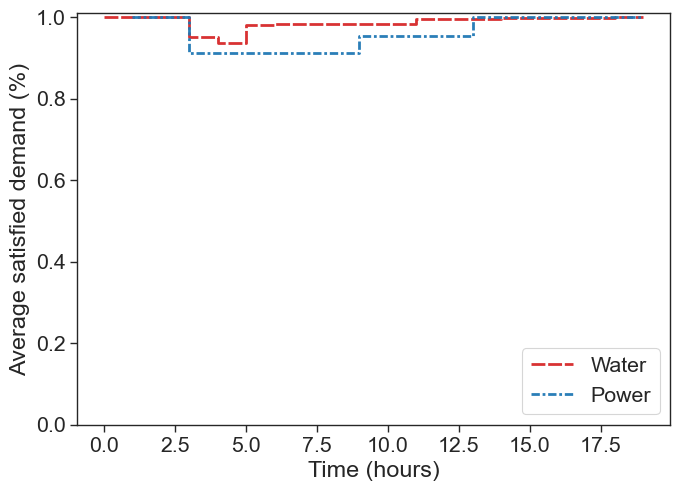

In [ ]:
model_plots.plot_interdependent_effects(resilience_metrics, metric = 'pcs', title = False)

### Location of disrupted components and crews

In [ ]:
model_plots.plot_disruptions_and_crews(shelby_network, basemap = True)

{'power': ['P_L2', 'P_L45', 'P_L46', 'P_L38', 'P_L54', 'P_L43'], 'water': ['W_PMA44', 'W_PMA53'], 'transpo': []}


Loading BokehJS ...

### Disruption to utility services

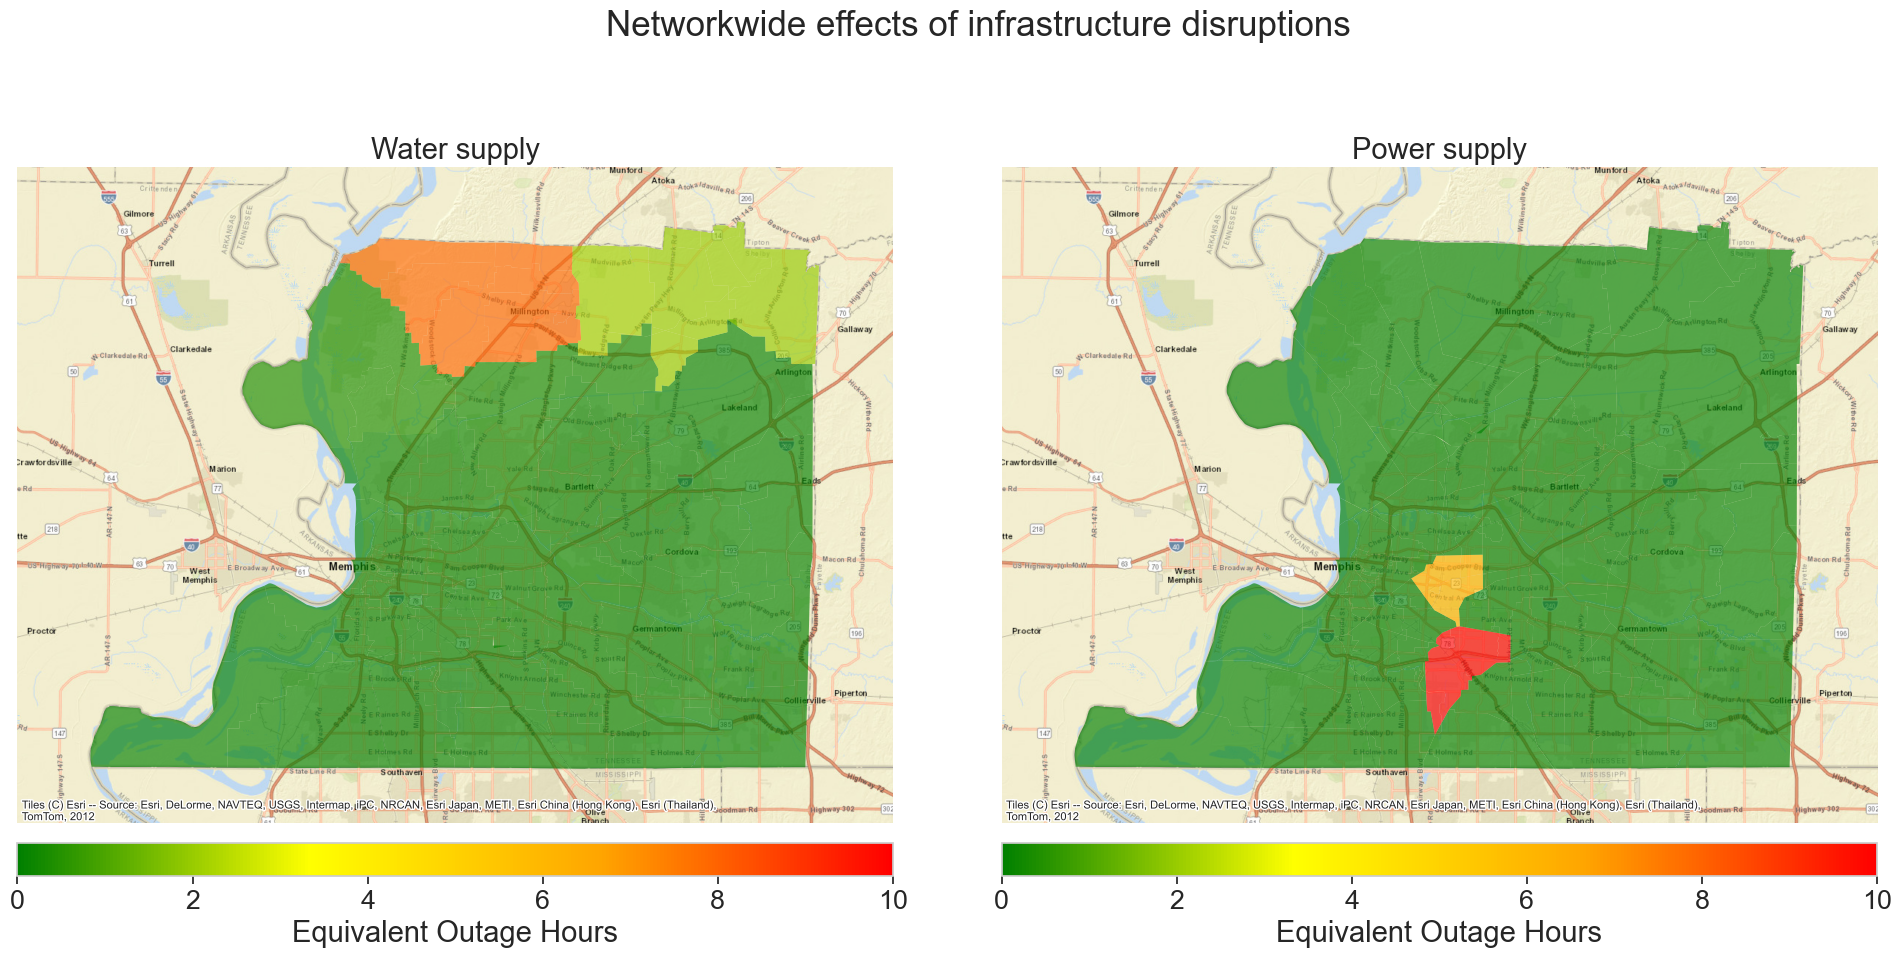

In [ ]:
split_water_sa = gpd.overlay(shelby_network.wn.service_area, ShelbySE.county_gpd_truncated, how='intersection')
split_power_sa = gpd.overlay(shelby_network.pn.service_area, ShelbySE.county_gpd_truncated, how='intersection')
sa_dict = {'Water': split_water_sa, 'Power': split_power_sa}

model_plots.plot_region_impact_map(resilience_metrics, sa_dict, "capacity", extends = ShelbySE.bounds)

### Direct business disruptions

In [ ]:
ShelbySE.plot_interactive(type = "economic costs")

interactive(children=(Dropdown(description='Industry', layout=Layout(width='max-content'), options=('Accommoda…